# 1. 데이터 준비
- tensor flow datasets 내 tf_flowers 데이터 사용 (tfds.load)

In [1]:
import warnings
warnings.filterwarnings("ignore")

print("완료!")

완료!


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds   # 텐서플로우가 제공하는 데이터셋 모음집
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, callbacks
%matplotlib inline

In [3]:
# 데이터 불러오기 + train, validation, test 나누기
(raw_train, raw_validation, raw_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /aiffel/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
# 데이터셋 확인
print(raw_train)
print(raw_validation)
print(raw_test)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


# 2. 데이터셋 확인 및 전처리
- 이미지 리사이징
- trian, validation, test batches 준비

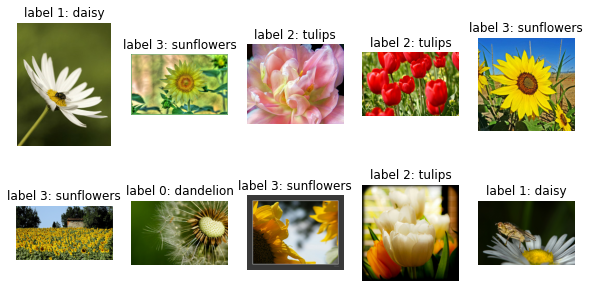

In [5]:
# 이미지 확인 (tf.data.Dataset에서 제공하는 take 함수 활용)
# 인수로 받은 개수만큼의 데이터 추출하여 새로운 데이터셋 인스턴스 생성

plt.figure(figsize=(10, 5))

get_label_name = ds_info.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져오기
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [6]:
# 이미지 사이즈 통일시키기
# format_example() 함수 : 이미지 사이즈 통일 + 픽셀값 스케일 조정

IMG_SIZE = 224
BATCH_SIZE = 32

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

print("완료!")

완료!


In [7]:
# train, val, test에 map함수 활용하여 format_example 적용
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


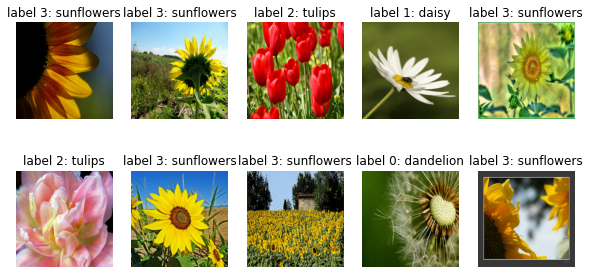

In [8]:
# 이미지 재확인
plt.figure(figsize=(10, 5))


get_label_name = ds_info.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2   # matplotlib으로 시각화 할 경우 모든 픽셀이 양수여야하므로 변환
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [9]:
# # 데이터 증강을 포함한 train_batches 정의 -> 성능 오히려 떨어져서 제외
# data_augmentation = models.Sequential([
#     layers.RandomFlip('horizontal'),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2)
# ])

In [10]:
# train, val, test에 map함수 활용하여 format_example 적용

train_batches = train.shuffle(1000).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# train_batches = train.map(lambda x, y: (data_augmentation(x, training=True), y)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# validation_batches = validation.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# test_batches = test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 3. 모델 설계 (Transfer learning)
- VGG16 가져오기
- 클래스 5개 주의

In [11]:
# base model 설계
# OUTPUT에 가까운 높은 레벨에 있는 3개의 FC레이어 제외 (include_top=False)

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [12]:
# 사전 학습 모델 가중치 고정
base_model.trainable = False

In [13]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),  # 추가된 FC layer
    layers.Dropout(0.5),  # Dropout layer 추가하여 과적합 방지
    layers.Dense(5, activation='softmax')  # tf_flowers는 5개의 클래스
])

In [14]:
# 모델 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


# 4. 모델 컴파일 및 학습
### (참고) 성능 개선 위해 시도 가능한 것들
- epoch, learning rate, optimizer 등 조정
- base model 변경
- 파인튜닝->fc layer 구성 변경
- regularization 적용
- drop out, batch normalization


## 4.1 컴파일

In [15]:
# 컴파일
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# 초기 손실 및 정확도 확인
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/20 [=================>............] - ETA: 3s - loss: 1.6992 - accuracy: 0.1526WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


20/20 [==============================] - 14s 233ms/step - loss: 1.6992 - accuracy: 0.1526
initial loss: 1.70
initial accuracy: 0.15


## 4.2 학습

In [17]:
# 학습
# EarlyStopping 콜백 추가
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                       callbacks=[early_stopping]
                   )

Epoch 1/10
92/92 [==============================] - 19s 191ms/step - loss: 1.5171 - accuracy: 0.3413 - val_loss: 1.2250 - val_accuracy: 0.6322
Epoch 2/10
92/92 [==============================] - 14s 144ms/step - loss: 1.2141 - accuracy: 0.5501 - val_loss: 1.0080 - val_accuracy: 0.7221
Epoch 3/10
92/92 [==============================] - 14s 143ms/step - loss: 1.0251 - accuracy: 0.6386 - val_loss: 0.8812 - val_accuracy: 0.7439
Epoch 4/10
92/92 [==============================] - 15s 147ms/step - loss: 0.9142 - accuracy: 0.6856 - val_loss: 0.7939 - val_accuracy: 0.7493
Epoch 5/10
92/92 [==============================] - 15s 148ms/step - loss: 0.8107 - accuracy: 0.7258 - val_loss: 0.7268 - val_accuracy: 0.7575
Epoch 6/10
92/92 [==============================] - 15s 149ms/step - loss: 0.7750 - accuracy: 0.7343 - val_loss: 0.6884 - val_accuracy: 0.7602
Epoch 7/10
92/92 [==============================] - 15s 149ms/step - loss: 0.7274 - accuracy: 0.7514 - val_loss: 0.6537 - val_accuracy: 0.7766

## 4.3 optimizer 변경해서 성능 비교(adam)

In [18]:
# optimizer 변경(adam)
learning_rate = 0.0001
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# 학습_ver.2(adam)
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                       callbacks=[early_stopping]
                   )

Epoch 1/10
92/92 [==============================] - 16s 151ms/step - loss: 0.6095 - accuracy: 0.7820 - val_loss: 0.5259 - val_accuracy: 0.8229
Epoch 2/10
92/92 [==============================] - 15s 152ms/step - loss: 0.5181 - accuracy: 0.8181 - val_loss: 0.4672 - val_accuracy: 0.8365
Epoch 3/10
92/92 [==============================] - 15s 153ms/step - loss: 0.4607 - accuracy: 0.8399 - val_loss: 0.4512 - val_accuracy: 0.8365
Epoch 4/10
92/92 [==============================] - 15s 152ms/step - loss: 0.4308 - accuracy: 0.8443 - val_loss: 0.4188 - val_accuracy: 0.8583
Epoch 5/10
92/92 [==============================] - 15s 150ms/step - loss: 0.3929 - accuracy: 0.8573 - val_loss: 0.4235 - val_accuracy: 0.8583
Epoch 6/10
92/92 [==============================] - 15s 151ms/step - loss: 0.3833 - accuracy: 0.8685 - val_loss: 0.3850 - val_accuracy: 0.8719
Epoch 7/10
92/92 [==============================] - 15s 150ms/step - loss: 0.3550 - accuracy: 0.8774 - val_loss: 0.3906 - val_accuracy: 0.8610

### 옵티마이저 변경 후 성능 개선!!!
- RMSprop: loss: 0.6274 - accuracy: 0.7830 - val_loss: 0.5856 - val_accuracy: 0.7902
- adam: loss: 0.3833 - accuracy: 0.8685 - val_loss: 0.3850 - val_accuracy: 0.8719

# 5. 성능 평가

In [25]:
# Test 데이터셋에 대한 성능 평가
test_loss, test_accuracy = model.evaluate(test_batches)
print(f"Test Accuracy: {test_accuracy:.4f}")

12/12 [==============================] - 2s 116ms/step - loss: 0.3571 - accuracy: 0.8774
Test Accuracy: 0.8774


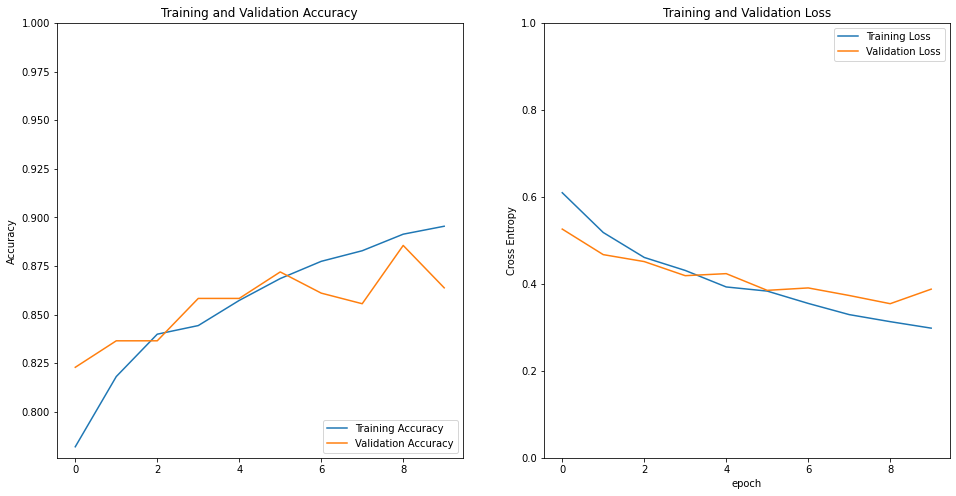

In [20]:
# 학습 과정 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
# TEST SAMPLE 예측 결과 확인
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.99973059e-01, 2.57005886e-05, 2.59863072e-07, 4.33211909e-07,
        4.60133833e-07],
       [9.69318807e-01, 2.92817950e-02, 5.21814509e-04, 6.32738578e-04,
        2.44807336e-04],
       [8.83809030e-01, 1.04106106e-01, 9.81196412e-04, 9.00011044e-03,
        2.10355106e-03],
       [1.53775662e-04, 5.54191647e-04, 7.41375804e-01, 1.78304632e-04,
        2.57737845e-01],
       [1.89822037e-02, 9.99578983e-02, 8.39796603e-01, 6.02217205e-03,
        3.52411047e-02],
       [1.77596718e-01, 8.03577423e-01, 1.05233907e-04, 1.81654394e-02,
        5.55194565e-04],
       [3.42392176e-02, 4.03701961e-02, 8.10378909e-01, 5.43923862e-03,
        1.09572425e-01],
       [9.96216238e-01, 2.22858856e-03, 1.30887973e-04, 1.34183641e-03,
        8.23961600e-05],
       [9.99984384e-01, 1.50475253e-05, 4.32335021e-08, 5.22617540e-07,
        3.69051669e-08],
       [4.76969779e-03, 4.80487215e-04, 2.77593429e-03, 9.82524335e-01,
        9.44957789e-03],
       [9.94430125e-01, 4.9399

In [22]:
# 예측값 라벨 변환
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 0, 2, 2, 1, 2, 0, 0, 3, 0, 4, 0, 3, 0, 2, 0, 2, 2, 0, 3, 4,
       1, 1, 0, 1, 3, 4, 3, 4, 4, 4])

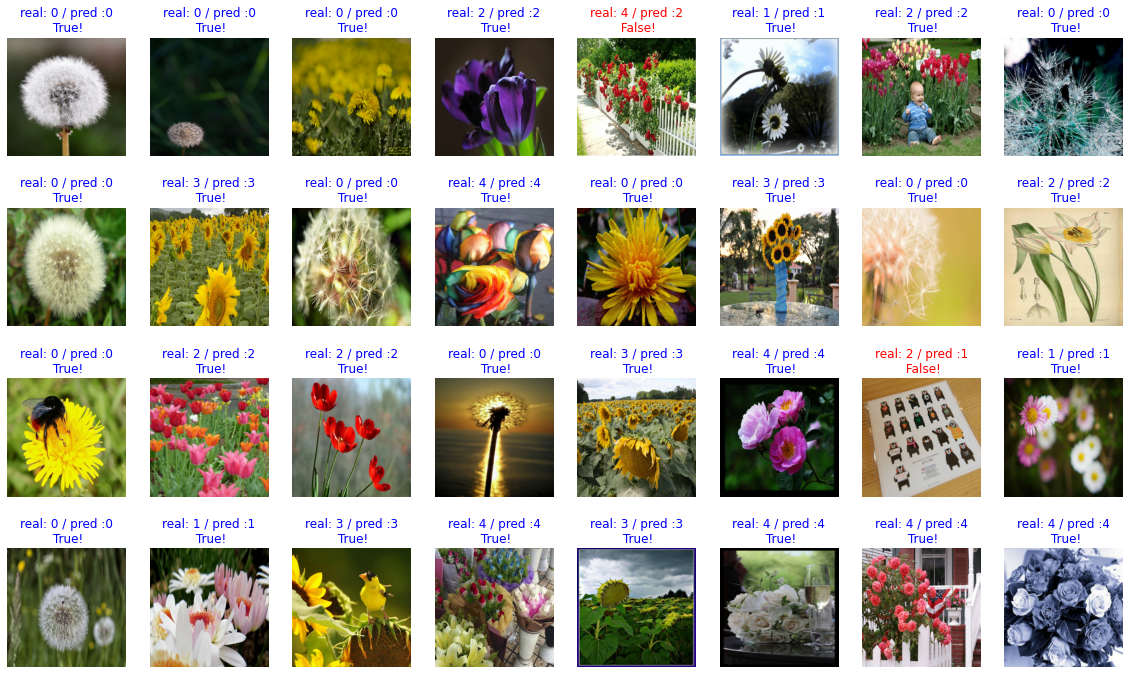

In [23]:
# 확인
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [24]:
# 정확도 확인
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)

93.75


# 6. 모델 활용
- 다른 이미지들 모델에 넣어보기

In [30]:
# 라벨에 어떤 꽃들이 있는지 확인
class_names = ds_info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [49]:
import requests
from PIL import Image
import numpy as np
import io

In [53]:
# 이미지 다운로드 및 전처리 함수
def load_and_preprocess_image_from_url(url, img_size=224):
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content)).convert('RGB')
    image = image.resize((img_size, img_size))  # 이미지 리사이징
    image = np.array(image) / 255.0  # 정규화
    image = np.expand_dims(image, axis=0)  # 배치 차원 추가
    return image

In [54]:
# 모델을 사용하여 이미지 예측 및 시각화 함수
def predict_and_show_image_from_url(url, model):
    image_batch = load_and_preprocess_image_from_url(url)
    # predict() 함수가 모델의 예상 입력 차원과 맞도록 확인
    if image_batch.shape[1:] != (224, 224, 3):
        raise ValueError(f"Expected input shape (224, 224, 3), but got shape {image_batch.shape[1:]}")
    
    predictions = model.predict(image_batch)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    # 이미지와 예측 결과 시각화
    plt.figure(figsize=(6, 6))
    plt.imshow(image_batch[0])  # 배치에서 이미지를 추출하여 시각화
    plt.title(f"Predicted: {class_names[predicted_class]}", fontsize=20)  # 폰트 크기 증가
    plt.axis('off')
    plt.show()

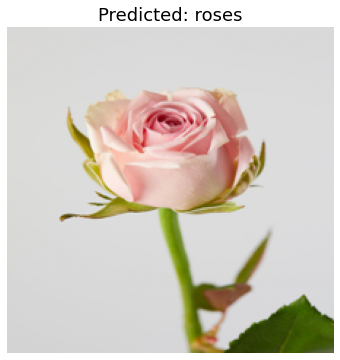

In [55]:
# 모델 테스트.1
image_url = 'https://d37uyz6vsycpqo.cloudfront.net/media/catalog/product/images/b7cbdc30-657e-48a9-96c5-bdf52c1ed7ae.jpg'
predict_and_show_image_from_url(image_url, model)

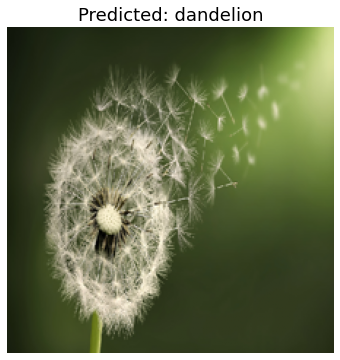

In [56]:
# 모델 테스트.2
image_url = 'https://www.flowerchimp.com/cdn/shop/articles/dandilieo_1000x.png?v=1680682667'
predict_and_show_image_from_url(image_url, model)

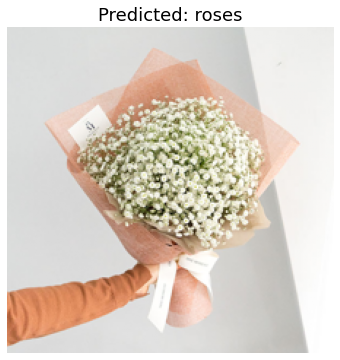

In [57]:
# 모델 테스트.3
image_url = 'https://s3.ap-northeast-2.amazonaws.com/om-public-static/media/images/products/2018/01/%EC%95%88%EA%B0%9C%EA%BD%83_1_SVP844O.jpg'
predict_and_show_image_from_url(image_url, model)

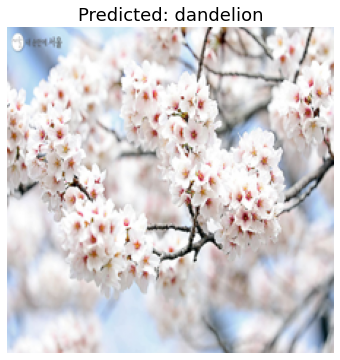

In [58]:
# 모델 테스트.4
image_url = 'https://mediahub.seoul.go.kr/uploads/mediahub/2022/03/HVcoUqjrSNnmlMuKSXqxLVDqIIgzHrUv.jpg'
predict_and_show_image_from_url(image_url, model)